# Forward modelling of scattering from 3D multilayer structures 

Lars Gebraad

_Copyright Mondaic AG, for the University of Bristol, January 2025._

This tutorial will showcases how Salvus can be used to model layered 3D structures.

In [1]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Main Salvus import
import salvus.namespace as sn

import salvus.mesh

SITE_NAME = "local"
RANKS = 8

# Most modern laptops will do this:
CENTRAL_FREQUENCY = 250e3  # 250 kHz
# High end laptop or workstation:
# CENTRAL_FREQUENCY = 1000e3  # 1 MHz

PROJECT_NAME = f"project_02_{int(CENTRAL_FREQUENCY)}"

--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.81 seconds]


## Creating a domain and project

In [2]:
# All units in Salvus are SI, so adding e-3 indicates millimeters.
domain = sn.domain.dim3.BoxDomain(
    x1=40e-3, x0=0, y1=40e-3, y0=0, z1=10e-3, z0=0
)
domain.plot()

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(100,100,100)', 'width': 4},
              'mode': 'lines',
              'name': 'Domain Outline',
              'type': 'scatter3d',
              'uid': '852deb46-23e0-4f99-ae75-b12edff12c7a',
              'x': array([0.  , 0.04, 0.04, 0.  , 0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.04, 0.04,
                          0.04, 0.04, 0.  , 0.  ]),
              'y': array([0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.  ,
                          0.04, 0.04, 0.04, 0.04]),
              'z': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
                          0.  , 0.01, 0.01, 0.  ])}],
    'layout': {'scene': {'aspectmode': 'data',
                         'camera': {'eye': {'x': 2, 'y': -2, 'z': 2}},
                         'xaxis': {'backgroundcolor': 'rgba(0, 0, 0, 0.1)', 'showbackground': True, 'ticks': 'outside'},
                         'y

In [3]:
# Once we have a domain we can initialize a project with a path on disk.
p = sn.Project.from_domain(
    path=PROJECT_NAME, domain=domain, load_if_exists=True
)

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-01-30 14:29:57,321] INFO: Loading project from project_02_250000.


## Source and receiver configuration: Array acquisition

In [38]:
sn.ReceiverChannel?

Init signature:
sn.ReceiverChannel(
    identifier: 'str',
    input_receivers: 'typing.Sequence[str]',
    input_receiver_weights: 'npt.NDArray[np.float64]',
    input_receiver_delays: 'typing.Optional[npt.NDArray[np.float64]]' = None,
)
Docstring:     
A receiver channel mapping multiple point receivers to a single output
channel.

Each output component of that channel will be a weighted, normalized sum of
each input component.

CHANNEL[COMPONENT_A] = (
    input_receiver_weights[0] * get_data(input_receivers[0])[COMPONENT_A] +
    input_receiver_weights[1] * get_data(input_receivers[1])[COMPONENT_A] +
    input_receiver_weights[2] * get_data(input_receivers[2])[COMPONENT_A] +
    ...
) / sum(input_receiver_weights)

Optionally, the individual input components can be time-shifted before
summation to support beamforming channels. Each receiver is time-shifted
according to input_receiver_delays.

Args:
    identifier: The name/identifier of the receiver channel.
    input_receivers: Th

In [4]:
@dataclasses.dataclass
class ArrayTransducer:
    # Represents a rectangular array transducer.
    nx: int
    ny: int
    dx: float
    dy: float
    x0: float
    y0: float

    # Update this per array if you want to add multiple, as the
    # receivers will use this name to identify themselves
    array_name: str = "array_0"

    recording_fields: list[str] = dataclasses.field(
        default_factory=lambda: ["displacement"]
    )

    # Determines on what side of the domain the array is attached
    side_set: str = "z1"

    def test_within_domain(self, domain: sn.domain.Domain) -> bool:
        # Determines whether the entire grid of the array transducer
        # is within a given domain.
        x_bounds = domain.bounds.hc["x"]
        y_bounds = domain.bounds.hc["y"]

        # Calculate the spatial bounds of the array transducer
        array_x_bounds = (self.x0, self.x0 + (self.nx - 1) * self.dx)
        array_y_bounds = (self.y0, self.y0 + (self.ny - 1) * self.dy)

        # Check if the array is fully within the domain bounds
        within_x = (
            x_bounds[0] <= array_x_bounds[0]
            and array_x_bounds[1] <= x_bounds[1]
        )
        within_y = (
            y_bounds[0] <= array_y_bounds[0]
            and array_y_bounds[1] <= y_bounds[1]
        )

        return within_x and within_y

    def create_salvus_source_receivers(
        self,
        source_index: tuple[int, int],
        f_source: tuple[int, int, int] = (0, 0, 1),
    ):
        # Function to create salvus sources and receivers from array
        si_x, si_y = source_index

        if si_x < 0 or si_y < 0 or si_x > self.nx - 1 or si_y > self.ny - 1:
            raise ValueError("Source index out of range.")

        array_coordinates = np.zeros((self.ny, self.nx, 2))
        for j in range(self.ny):
            for i in range(self.nx):
                array_coordinates[j, i] = [
                    self.x0 + i * self.dx,
                    self.y0 + j * self.dy,
                ]

        # Calculate all sources
        source_x, source_y = array_coordinates[si_y, si_x, ...]

        fx, fy, fz = f_source

        source = sn.simple_config.source.cartesian.SideSetVectorPoint3D(
            # Note that this 0 for Z is used for starting the projection
            # on the side set, it is not the coordinate of the source.
            point=(source_x, source_y, 0),
            fx=fx,
            fy=fy,
            fz=fz,
            direction="z",
            side_set_name=self.side_set,
        )

        receivers = [
            sn.simple_config.receiver.cartesian.SideSetPoint3D(
                direction="z",
                point=(
                    array_coordinates[j, i, 0],
                    array_coordinates[j, i, 1],
                    0,
                ),
                # Note that we're using leading zeros, but if nx/ny is
                # really high this needs to be scaled up.
                station_code=f"{self.array_name}_x{i:03d}_y{j:03d}",
                fields=self.recording_fields,
                side_set_name=self.side_set,
            )
            for j in range(self.ny)
            for i in range(self.nx)
        ]

        return source, receivers

    def plot_in_domain(
        self,
        domain: sn.domain.Domain,
        source_index: tuple[int, int] | None = None,
    ):
        # Plots the array transducer within the given domain using Matplotlib.

        # Domain bounds
        x_bounds = domain.bounds.hc["x"]
        y_bounds = domain.bounds.hc["y"]

        # Create array coordinates as a 3D numpy array with shape (ny, nx, 2)
        # Note that first dimension is Y!
        array_coordinates = np.zeros((self.ny, self.nx, 2))
        for j in range(self.ny):
            for i in range(self.nx):
                array_coordinates[j, i] = [
                    self.x0 + i * self.dx,
                    self.y0 + j * self.dy,
                ]

        # Plot the domain
        plt.figure(figsize=(8, 8))
        plt.plot(
            [x_bounds[0], x_bounds[1], x_bounds[1], x_bounds[0], x_bounds[0]],
            [y_bounds[0], y_bounds[0], y_bounds[1], y_bounds[1], y_bounds[0]],
            label="Domain",
            color="blue",
            linestyle="--",
        )

        # Plot the array transducer
        x_coords = array_coordinates[:, :, 0].flatten()
        y_coords = array_coordinates[:, :, 1].flatten()
        plt.scatter(x_coords, y_coords, color="red", label="Array Elements")

        if source_index is not None:
            plt.scatter(
                # Note that the array coordinates are ordered reversely, first
                # dimension of array coordinates are the y receivers.
                *array_coordinates[*source_index[::-1], ...],
                color="blue",
                label="selected source",
            )

        # Plot settings
        plt.title("Array Transducer within Domain")
        plt.xlabel("X Coordinate (m)")
        plt.ylabel("Y Coordinate (m)")
        plt.legend()
        plt.grid(True)
        plt.axis("equal")
        plt.show()

In [5]:
array_1 = ArrayTransducer(
    nx=15, ny=10, x0=5e-3, y0=5e-3, dx=2e-3, dy=2e-3, array_name="array_0"
)

array_1.test_within_domain(domain)

True

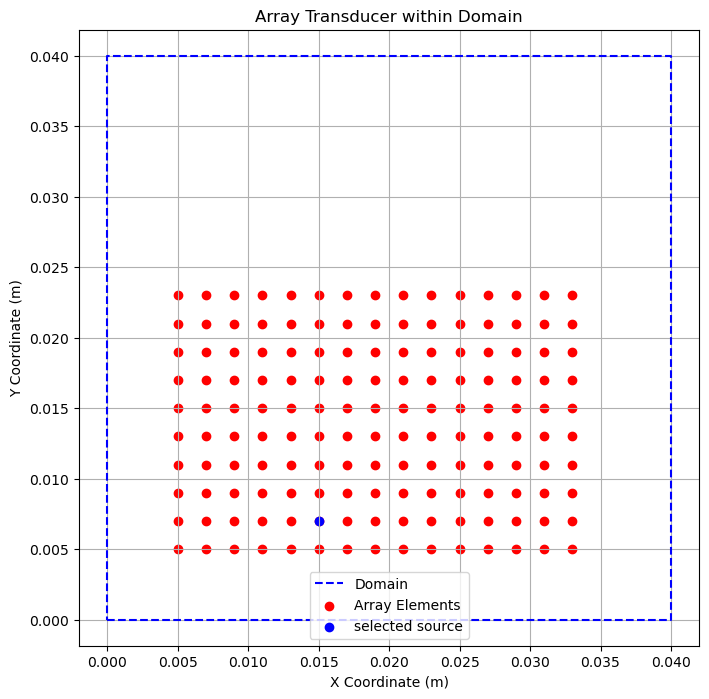

In [6]:
array_1.plot_in_domain(domain, source_index=(5, 1))

In [7]:
source, receivers = array_1.create_salvus_source_receivers(source_index=(1, 1))

In [8]:
# Linearly indexed, so (nx-1) + 1 gives index (1,1)
receivers[array_1.nx + 1].to_json()

{'class_name': 'salvus.flow.simple_config.receiver.cartesian.SideSetPoint3D',
 'salvus_version': '2024.1.2',
 'arguments': {'offset': 0.0,
  'network_code': 'XX',
  'location_code': '',
  'direction': 'z',
  'point': [0.007, 0.007, 0],
  'station_code': 'array_0_x001_y001',
  'fields': ['displacement'],
  'side_set_name': 'z1'}}

In [9]:
event = sn.Event(
    event_name="array_a_source_(1,1)", sources=source, receivers=receivers
)

p += event

[2025-01-30 14:29:57,581] INFO: An event with name 'array_a_source_(1,1)' and identical content already exists in the project. Nothing will be done.


In [10]:
p.viz.nb.domain()

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(100,100,100)', 'width': 4},
              'mode': 'lines',
              'name': 'Domain Outline',
              'type': 'scatter3d',
              'uid': 'b32ed45f-0ea7-44d2-aa65-112f2184bb50',
              'x': array([0.  , 0.04, 0.04, 0.  , 0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.04, 0.04,
                          0.04, 0.04, 0.  , 0.  ]),
              'y': array([0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.  , 0.04, 0.04, 0.  , 0.  , 0.  ,
                          0.04, 0.04, 0.04, 0.04]),
              'z': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
                          0.  , 0.01, 0.01, 0.  ])}],
    'layout': {'scene': {'aspectmode': 'data',
                         'camera': {'eye': {'x': 2, 'y': -2, 'z': 2}},
                         'xaxis': {'backgroundcolor': 'rgba(0, 0, 0, 0.1)', 'showbackground': True, 'ticks': 'outside'},
                         'y

## Creating layered models

In [11]:
# Autodetection of material type
material_1 = sn.material.from_params(rho=5000, vp=3500, vs=2000)

type(material_1)

salvus.material.elastic.isotropic.Velocity

salvus.material.elastic.isotropic.Velocity

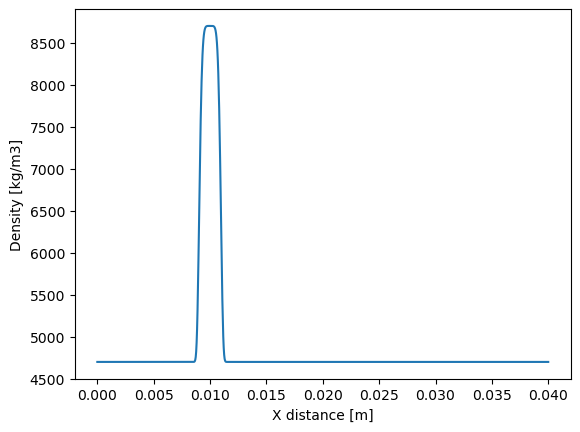

In [12]:
x = np.linspace(0, 0.04, 1000)

rho_0 = 4700.0 # kg/m3
rho = rho_0 * np.ones_like(x)
rho += (np.exp(-(((x - 0.01) / 0.001) ** 6))) * 4000

plt.plot(x, rho)
plt.xlabel("X distance [m]")
plt.ylabel("Density [kg/m3]")

ds = xr.DataArray(
    rho,
    coords={"x": x},
)

orientation = xr.DataArray(
    ... image_orientation,
    coords={"x": pixel_coordinate_x, "y": pixel_coordinate_y},
)


# When material type is know, we can investigate what parameters are needed
material_2_with_scatterer = sn.material.elastic.isotropic.Velocity.from_params(
    rho=ds, vp=6500, vs=4900
)

# material_2_without_scatterer = sn.material.elastic.isotropic.Velocity.from_params(
#     rho=rho_0, vp=6500, vs=4900
# )

type(material_2_with_scatterer)

In [14]:
material_3 = sn.material.elastic.hexagonal.Velocity.from_params(
    rho=4700, vph=6100, vpv=6500, vsh=4900, vsv=4500, eta=0
)


# Note that this material is of hexagonal symmetry!
type(material_3)

salvus.material.elastic.hexagonal.Velocity

In [15]:
sn.layered_meshing.interface.hyperplane.Hyperplane.at

<bound method Hyperplane.at of <class 'salvus.mesh.layered_meshing.interface.hyperplane.Hyperplane'>>

In [16]:
z_bottom, z_top = domain.bounds.vc["z"]

print(f"Domain vertical bounds: {z_bottom} - {z_top}m")

interface_m1_m2 = sn.layered_meshing.interface.Hyperplane.at(
    z_bottom + (2 / 3) * (z_top - z_bottom)
)

interface_m2_m3 = sn.layered_meshing.interface.Hyperplane.at(
    z_bottom + (1 / 3) * (z_top - z_bottom)
)

Domain vertical bounds: 0.0 - 0.01m


In [17]:
# All materials should be of the same type when simulating
conversion = sn.material.elastic.hexagonal.Velocity.from_material


# Defined from top to bottom
layered_model = sn.layered_meshing.LayeredModel(
    [
        conversion(material_1),
        interface_m1_m2,
        conversion(material_2_with_scatterer),
        interface_m2_m3,
        conversion(material_3),
    ]
)


In [18]:
mr = sn.MeshResolution(
    reference_frequency=CENTRAL_FREQUENCY * 2 * 5,
    elements_per_wavelength=1.5,
    model_order=2,
)

In [19]:
layered_model_with_absorbing_boundaries = sn.layered_meshing.MeshingProtocol(
    layered_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=["z0", "z1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

In [20]:
mesh = sn.layered_meshing.mesh_from_domain(
    domain=domain,
    model=layered_model_with_absorbing_boundaries,
    mesh_resolution=mr,
)

mesh

Please note that in the example above, the VP and VS field are only defined for the isotropic material. The anistropic material has its own velocities defined in horizontal and vertical modes.


## Running the simulation

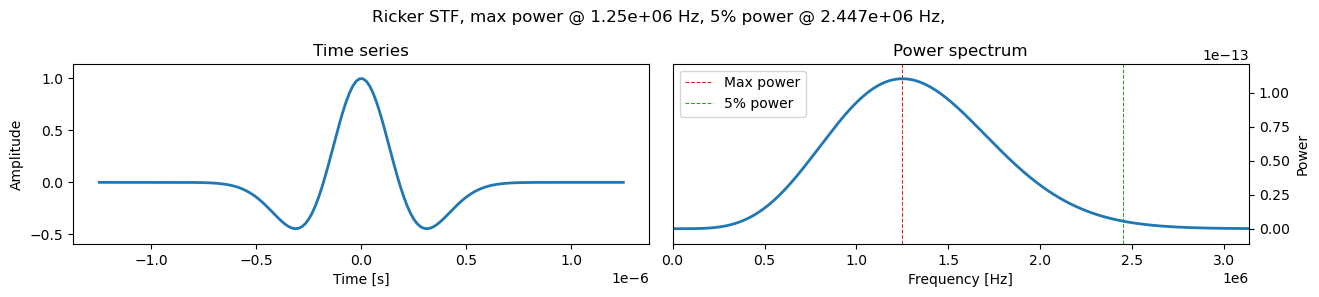

In [21]:
stf = sn.simple_config.stf.Ricker(center_frequency=CENTRAL_FREQUENCY * 5)

stf.plot()

In [22]:
end_time = 2e-5

sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh,
    name="sc_mesh_1_MIDFREQ",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

# p.entities.delete(entity_name="sc_mesh_1_HIGHFREQ", entity_type="simulation_configuration")

In [23]:
p += sc

[2025-01-30 14:30:31,963] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [24]:
p.viz.nb.simulation_setup("sc_mesh_1", events="array_a_source_(1,1)")

Locating 150 item(s)::   0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
# Useful to visualize in ParaView
OUTPUT_VOLUME = True

if OUTPUT_VOLUME:
    output_conf = {
        "volume_data": {
            "sampling_interval_in_time_steps": 25*5,
            "fields": ["displacement"],
        }
    }
else:
    output_conf = {}

p.simulations.launch(
    simulation_configuration="sc_mesh_1_MIDFREQ",
    events="array_a_source_(1,1)",
    site_name="local",
    ranks_per_job=8,
    extra_output_configuration=output_conf,
    delete_conflicting_previous_results=True,
)

[2025-01-30 14:30:56,927] INFO: Data for 1 event(s) already exists. They will not be submitted again. The requested extra_output_configuration is fully contained in the existing results. If you really want to rerun the simulations, please delete the results first using p.simulations.delete_results().


0

In [26]:
p.simulations.query(
    block=True,
    simulation_configuration="sc_mesh_1_MIDFREQ",
    events="array_a_source_(1,1)",
)

VBox()

True

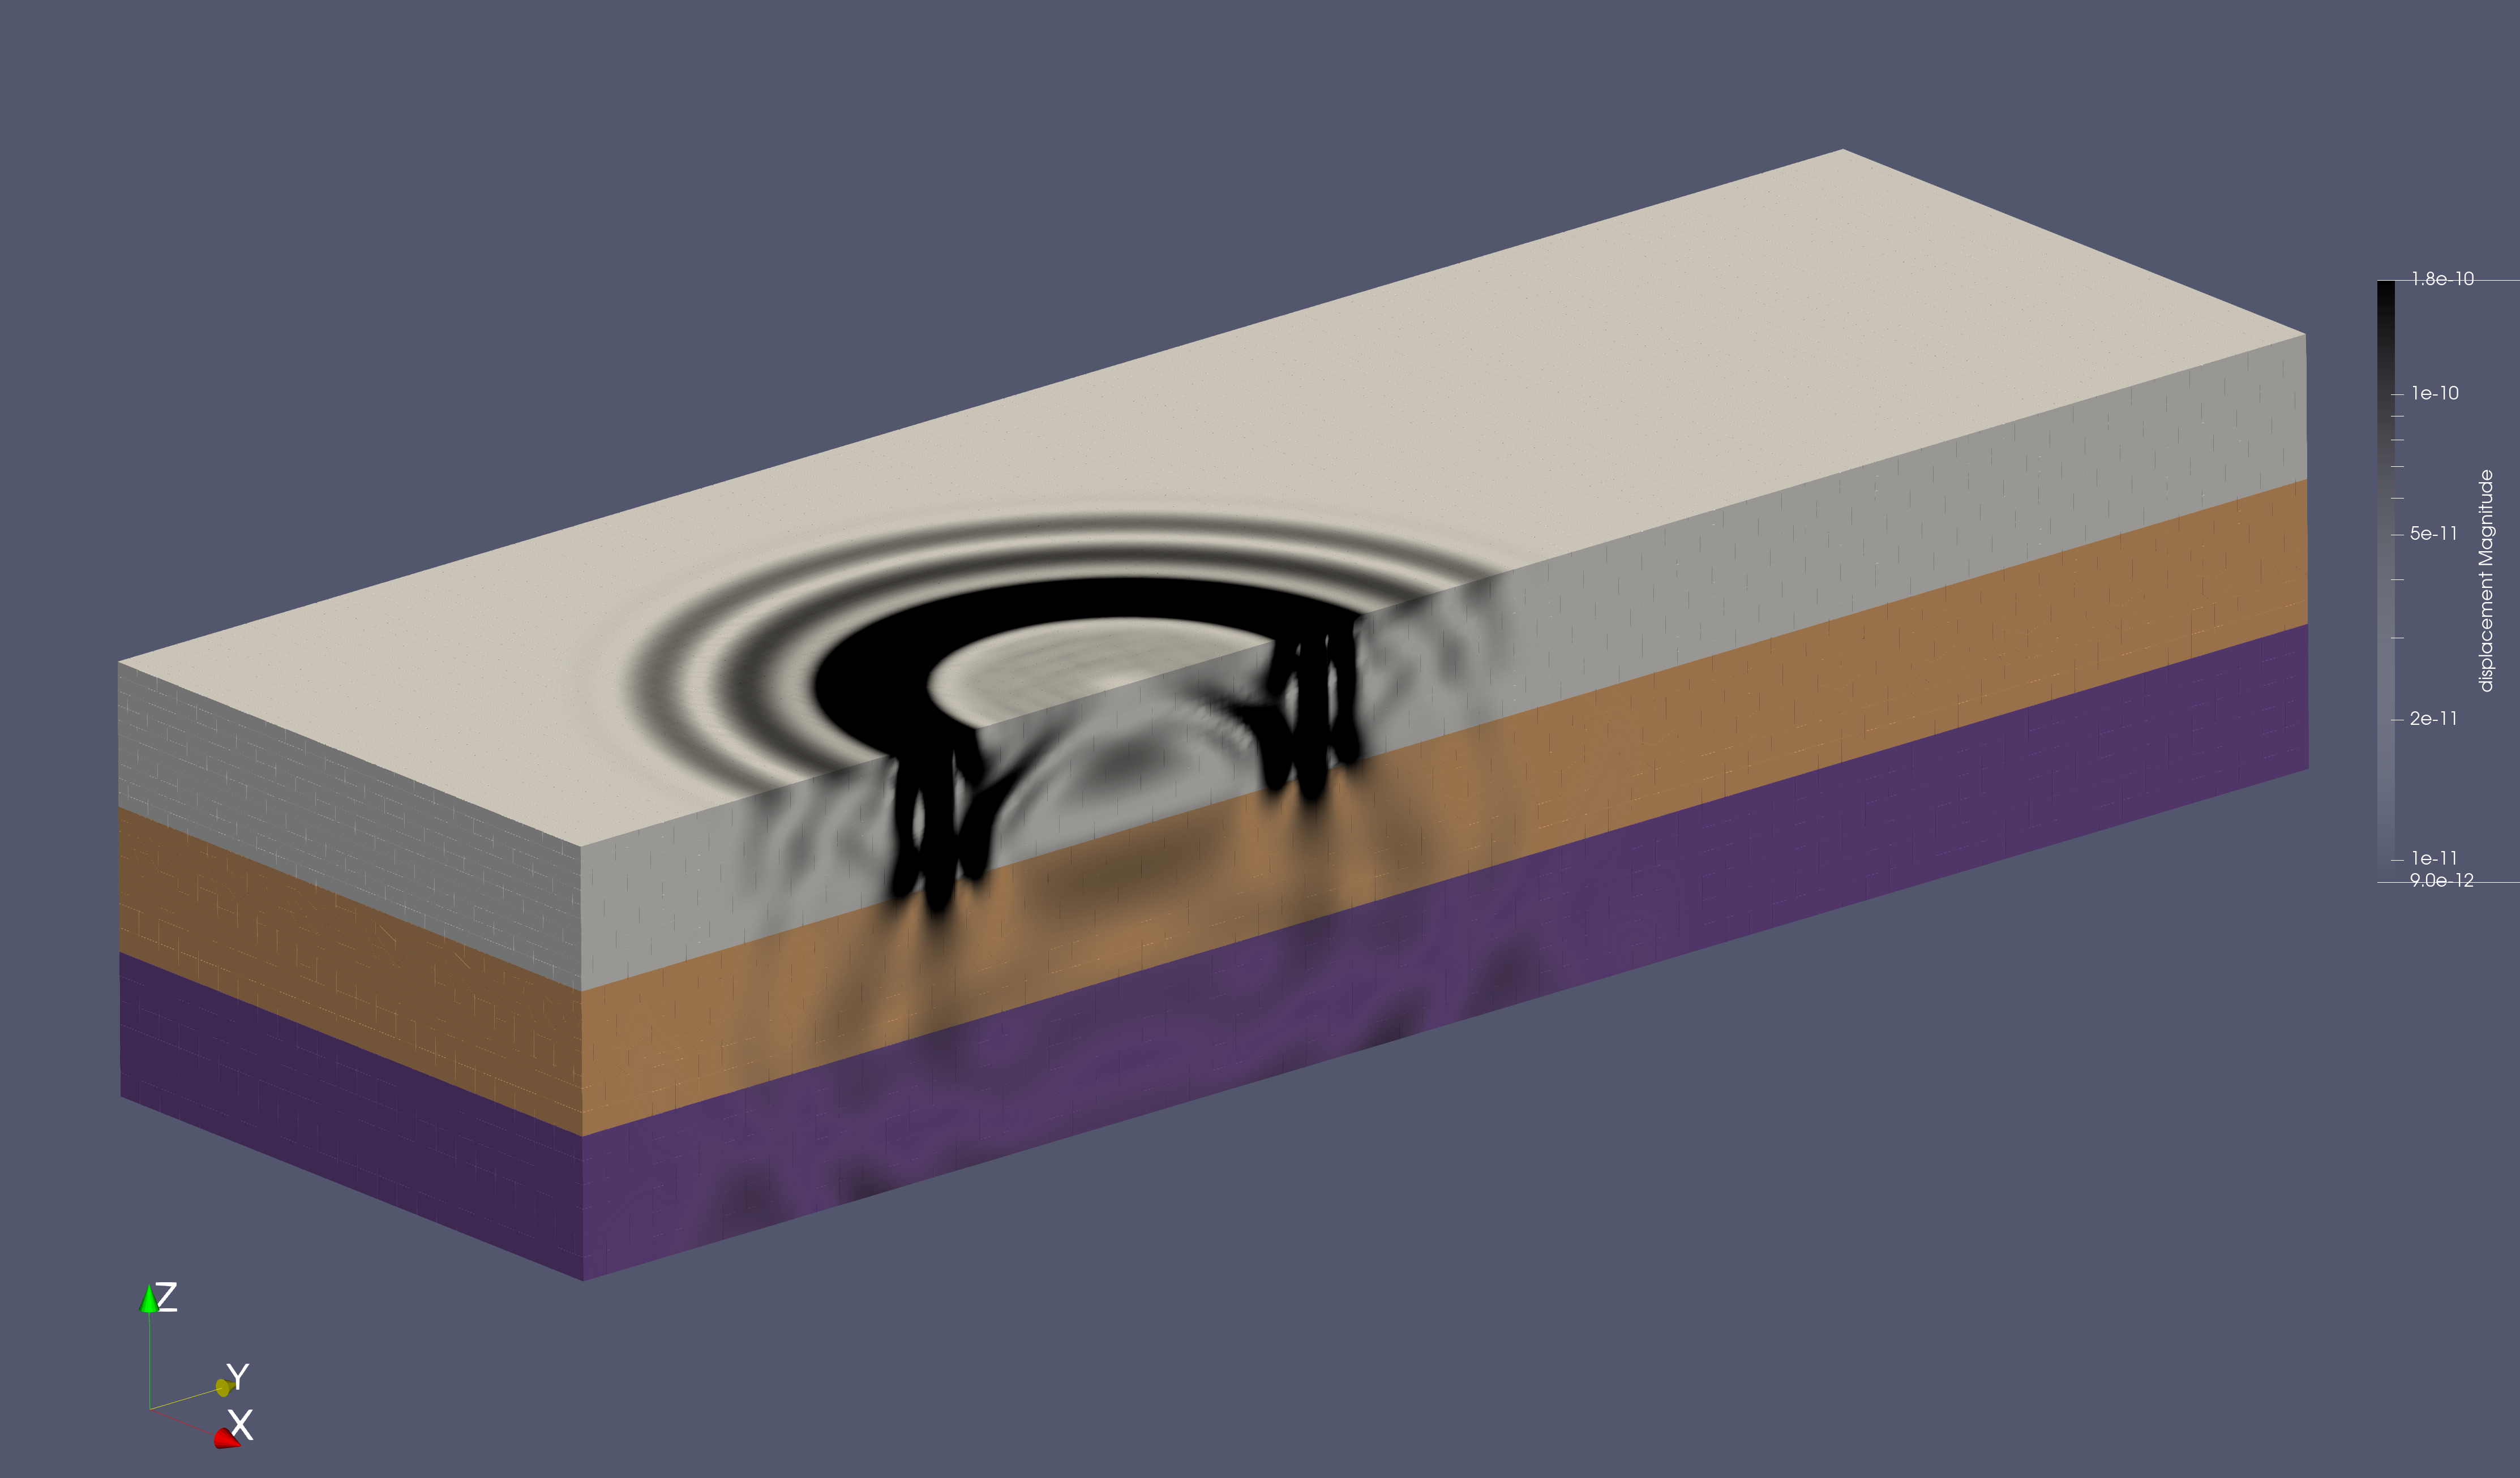

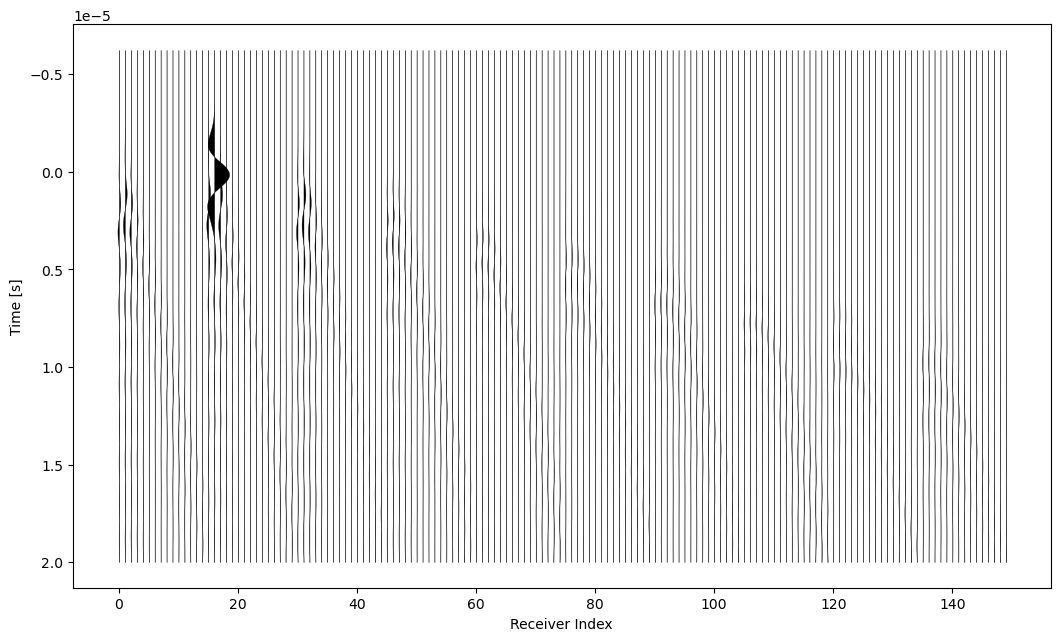

In [27]:
event_data = p.waveforms.get("sc_mesh_1", "array_a_source_(1,1)")[0]

event_data.plot(receiver_field="displacement", component="z")

## Data analysis using XArray

In [28]:
displacement = event_data.get_waveform_data_xarray(
    receiver_field="displacement"
)

Text(0.5, 1.0, 'Displacement Z recordings at various locations')

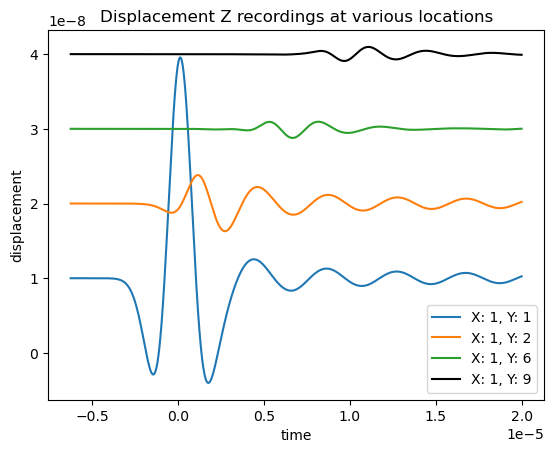

In [29]:
# The plotting below is made a lot more clear by adding some constant offset to the data,
# s.t. they are not plotted directly on top of eachother. This is done inline so the
# original data is modified.

# This is the exact source position as well, so will
# give really high amplitudes
(
    displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y001."])
    + 1e-8
).plot(label="X: 1, Y: 1")


# This is the next position in the array.
(
    displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y002."])
    + 2e-8
).plot(label="X: 1, Y: 2")


(
    displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y006."])
    + 3e-8
).plot(label="X: 1, Y: 6")
(
    displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y009."])
    + 4e-8
).plot(label="X: 1, Y: 9", c="k")

plt.legend()
plt.title("Displacement Z recordings at various locations")

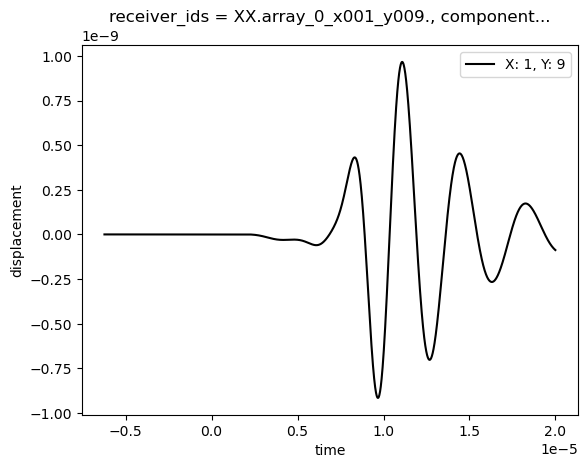

In [30]:
displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y009."]).plot(
    label="X: 1, Y: 9", c="k"
)
plt.legend()

Text(0.5, 1.0, 'Displacement Z')

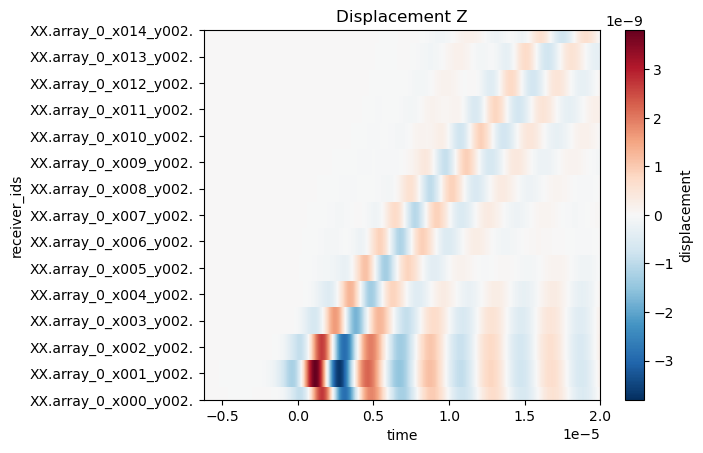

In [31]:
selection = [f"XX.array_0_x{ix:03d}_y002." for ix in range(array_1.nx)]

displacement.sel(components="Z", receiver_ids=selection).plot()

plt.title("Displacement Z")

Text(0.5, 1.0, 'Displacement magnitude')

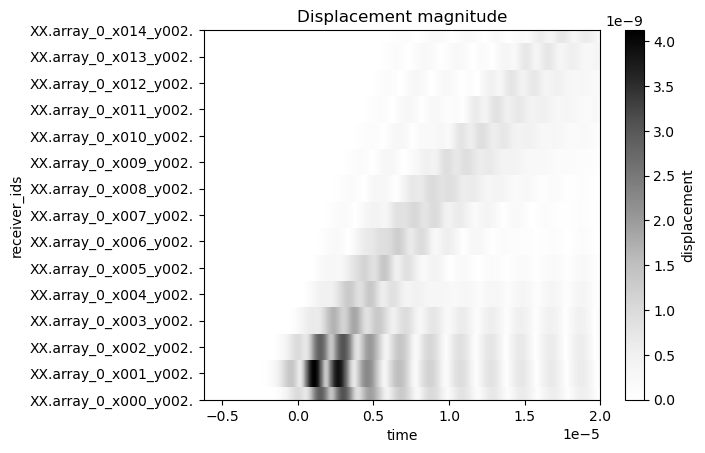

In [32]:
# XArray shows how one can define new functions over dimensions:
# https://docs.xarray.dev/en/stable/user-guide/computation.html
def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(
        np.linalg.norm,
        x,
        input_core_dims=[[dim]],
        kwargs={"ord": ord, "axis": -1},
    )


vector_norm(
    displacement.sel(
        # Note that using .sel also allows you to order data
        receiver_ids=selection[::1]
    ),
    dim="components",
).plot(cmap="Grays")

plt.title("Displacement magnitude")

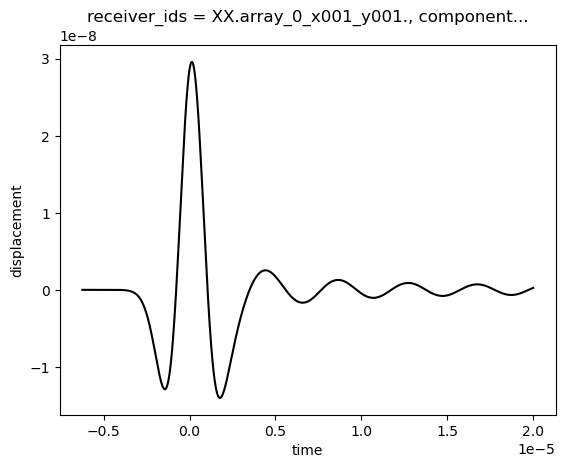

In [33]:
displacement.sel(components="Z", receiver_ids=["XX.array_0_x001_y001."]).plot(
    label="X: 1, Y: 9", c="k"
)

## Doing a line scan

In [34]:
ix = 1
for iy in range(array_1.ny):
    source, receivers = array_1.create_salvus_source_receivers(
        source_index=(ix, iy)
    )

    event_name = f"array_a_source_({ix},{iy})"

    print(f"Adding event: {event_name}")
    event = sn.Event(
        event_name=event_name, sources=source, receivers=receivers
    )

    p += event

Adding event: array_a_source_(1,0)
[2025-01-30 14:31:05,555] INFO: An event with name 'array_a_source_(1,0)' and identical content already exists in the project. Nothing will be done.
Adding event: array_a_source_(1,1)
[2025-01-30 14:31:05,595] INFO: An event with name 'array_a_source_(1,1)' and identical content already exists in the project. Nothing will be done.
Adding event: array_a_source_(1,2)
[2025-01-30 14:31:05,631] INFO: An event with name 'array_a_source_(1,2)' and identical content already exists in the project. Nothing will be done.
Adding event: array_a_source_(1,3)
[2025-01-30 14:31:05,669] INFO: An event with name 'array_a_source_(1,3)' and identical content already exists in the project. Nothing will be done.
Adding event: array_a_source_(1,4)
[2025-01-30 14:31:05,704] INFO: An event with name 'array_a_source_(1,4)' and identical content already exists in the project. Nothing will be done.
Adding event: array_a_source_(1,5)
[2025-01-30 14:31:05,741] INFO: An event with

In [35]:
ix = 1
selected_events_line = [
    f"array_a_source_({ix},{iy})" for iy in range(array_1.ny)
]
p.simulations.launch(
    simulation_configuration="sc_mesh_1",
    events=selected_events_line,
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)
p.simulations.query(block=True)

[2025-01-30 14:31:11,172] INFO: Simulations of 9 event(s) are still running. They will not be submitted again.
[2025-01-30 14:31:11,173] INFO: Data for 1 event(s) already exists. They will not be submitted again.


VBox()

True

The following shows the direct data below each source simulated.

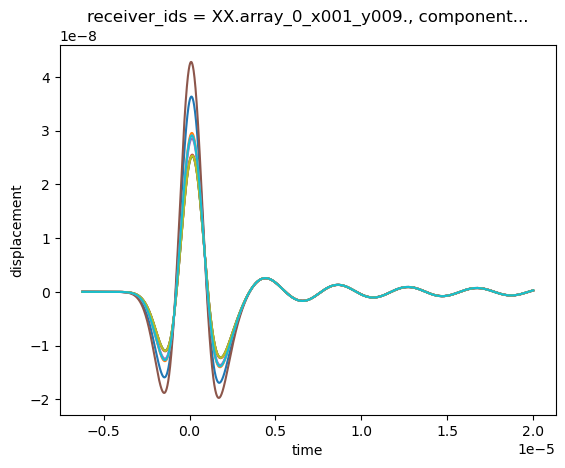

In [36]:
ix = 1

for iy in range(array_1.ny):

    event_name = f"array_a_source_({ix},{iy})"
    receiver_at_source = f"XX.array_0_x{ix:03d}_y{iy:03d}."

    event_data = p.waveforms.get("sc_mesh_1", event_name)[0]

    displacement = event_data.get_waveform_data_xarray(
        receiver_field="displacement"
    )

    displacement_Z_below_source = displacement.sel(
        receiver_ids=[receiver_at_source], components="Z"
    )

    displacement_Z_below_source.plot()

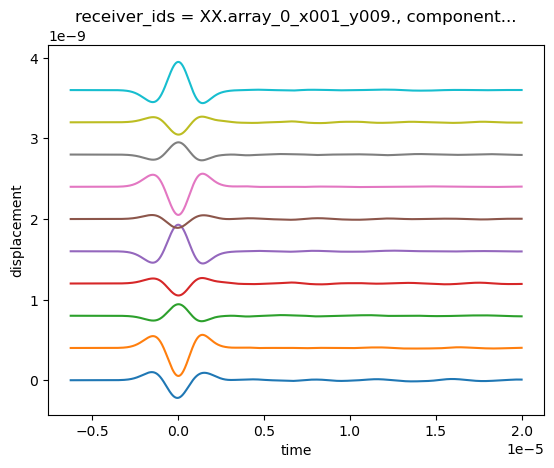

In [37]:
ix = 1

for iy in range(array_1.ny):

    event_name = f"array_a_source_({ix},{iy})"
    receiver_at_source = f"XX.array_0_x{ix:03d}_y{iy:03d}."

    event_data = p.waveforms.get("sc_mesh_1", event_name)[0]

    displacement = event_data.get_waveform_data_xarray(
        receiver_field="displacement"
    )

    displacement_Z_below_source = (
        displacement.sel(receiver_ids=[receiver_at_source], components="Y")
        + iy * 4e-10
    )

    displacement_Z_below_source.plot()